# Лабораторная работа №3 Апериодические сигналы

Кобыжев Александр, группа 3530901/80202

### Упражнение 3.1

In [1]:
from __future__ import print_function, division

%matplotlib inline

import thinkdsp
import thinkplot
import numpy as np

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

Пример утечки:

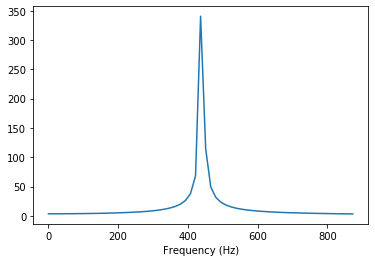

In [2]:
signal = thinkdsp.SinSignal(freq=440)
duration = signal.period * 30.25
wave = signal.make_wave(duration)
spectrum = wave.make_spectrum()

spectrum.plot(high=880)
thinkplot.config(xlabel='Frequency (Hz)')

Заменим окно Хэмминга на другие 4 окна.

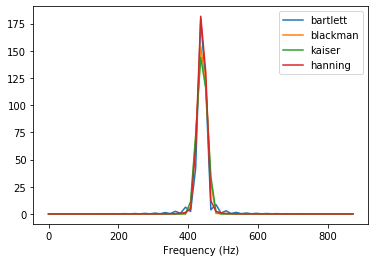

In [3]:
for window_func in [np.bartlett, np.blackman, np.kaiser, np.hanning]:
    wave = signal.make_wave(duration)
    if window_func.__name__ == "kaiser":
        wave.ys *= window_func(len(wave.ys), 10)
    else:
        wave.ys *= window_func(len(wave.ys))
    spectrum = wave.make_spectrum()
    spectrum.plot(high=880, label=window_func.__name__)

thinkplot.config(xlabel='Frequency (Hz)', legend=True)

Все четыре окна хорошо справляются с задачей уменьшения утечки. 

### Упражнение 3.2

Напишем класс `SawtoothChirp`, который переопределяет `evaluate` для генерации пилообразного сигнала.

In [4]:
import math
PI2 = 2 * math.pi

class SawtoothChirp(thinkdsp.Chirp):
    def evaluate(self, ts):
        freqs = np.linspace(self.start, self.end, len(ts) - 1)
        dts = np.diff(ts)
        dphis = PI2 * freqs * dts
        phases = np.cumsum(dphis)
        phases = np.insert(phases, 0, 0)
        cycles = phases / PI2
        frac, _ = np.modf(cycles)
        ys = self.amp * frac
        return ys

Теперь прослушаем получившийся звук и рассмотрим спектрограмму.

In [5]:
signal = SawtoothChirp(start=300, end=900)
wave = signal.make_wave(duration=1, framerate=10000)
wave.apodize()
wave.make_audio()

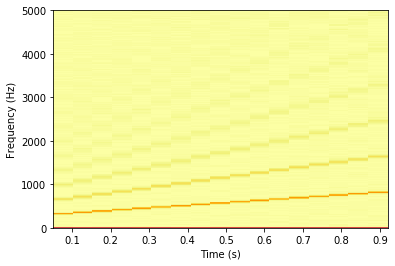

In [6]:
sp = wave.make_spectrogram(1024)
sp.plot()
thinkplot.config(xlabel='Time (s)', ylabel='Frequency (Hz)')

### Упражнение 3.3

Поскольку основная частота колеблется от 2500 до 3000 Гц, я ожидаю увидеть что-то вроде высокой башни в этом диапазоне. Первая гармоника колеблется от 5000 до 6000 Гц, поэтому я ожидаю более короткую башню в данном диапазоне. Вторая гармоника колеблется от 7500 до 9000 Гц, поэтому я ожидаю что-то еще более короткое в этом диапазоне.

Другие гармоники повсюду накладываются друг на друга, поэтому я ожидаю увидеть некоторую энергию на всех других частотах. Эта распределённая энергия создает интересные звуки.

In [7]:
signal = SawtoothChirp(start=2500, end=3000)
wave = signal.make_wave(duration=1, framerate=20000)
wave.make_audio()

Теперь посмотрим на получившийся спектр.

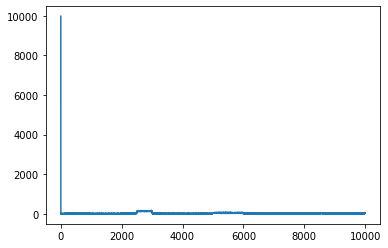

In [8]:
wave.make_spectrum().plot()

Получился похожий график спектра, как я и предполагал, но нам мешает большая частота в самом начале, поэтому уберём её для более детального просмотра спектра звука.

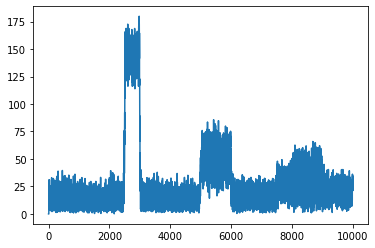

In [9]:
cut_wave = wave.make_spectrum()
cut_wave.high_pass(10)
cut_wave.plot()

Теперь гармоники можно чётко разглядеть.

### Упражнение 3.4

Для данного задания я нашёл в интернете глиссандо на скрипке.

In [10]:
wave = thinkdsp.read_wave('411728__inspectorj__violin-glissando-ascending-a-h1.wav')
wave.make_audio()

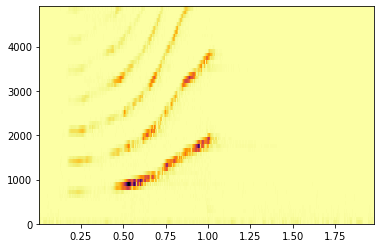

In [11]:
wave.make_spectrogram(512).plot(high=5000)

Теперь мы можем наблюдать глиссандо.

### Упражнение 3.5

Написанный класс представляет собой тромбоноподобный сигнал с переменной частотой.

In [14]:
class TromboneGliss(thinkdsp.Chirp):
    def _evaluate(self, ts):
        l1, l2 = 1.0 / self.start, 1.0 / self.end
        lengths = np.linspace(l1, l2, len(ts)-1)
        freqs = 1 / lengths
        return self._evaluate(ts, freqs)

Первая часть звука.

In [27]:
low = 262
high = 349
signal = TromboneGliss(low, high)
wave1 = signal.make_wave(duration=1)
wave1.apodize()
wave1.make_audio()

Вторая часть звука.

In [28]:
signal = TromboneGliss(high, low)
wave2 = signal.make_wave(duration=1)
wave2.apodize()
wave2.make_audio()

Соединим обе части звука вместе.

In [29]:
wave = wave1 | wave2
wave.make_audio()

Теперь сделаем спектрограмму и рассмотрим её.

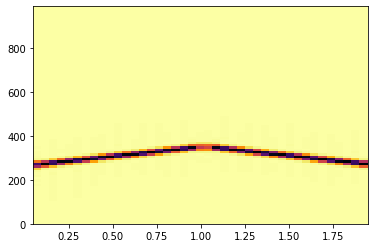

In [30]:
sp = wave.make_spectrogram(1024)
sp.plot(high=1000)

Глиссандо на тромбоне похоже на линейный чирп.

### Упражнение 3.6

В интернете нашёл гласные звуки, записанные женщиной, голос которой похож на голос бабы-яги из советских фильмов.

In [31]:
wave = thinkdsp.read_wave('337631__anaphy__female-creak-vowels-a-e-i-o-u.wav')
wave.make_audio()

Теперь сделаем спектрограмму.

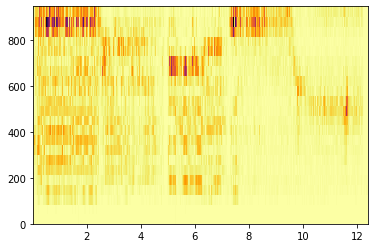

In [32]:
wave.make_spectrogram(1024).plot(high=1000)

Пики на спектрограмме называются формантами. В общем, гласные звуки различаются соотношением амплитуд первых двух формант относительно основного тона.

Мы можем увидеть форманты более чётко, выбрав сегмент во время «а».

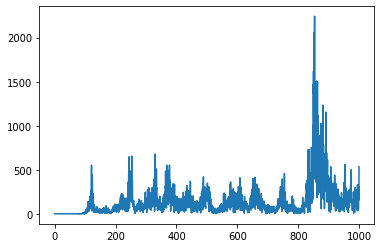

In [33]:
high = 1000
thinkplot.preplot(5)

segment = wave.segment(start=0, duration=2)
segment.make_spectrum().plot(high=high)

Основная частота около 100 Гц. Следующие самые высокие пики находятся на 300 Гц и 900 Гц.

Выберем сегмент «е».

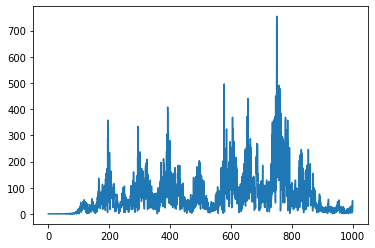

In [34]:
segment = wave.segment(start=2.5, duration=2)
segment.make_spectrum().plot(high=high)

Основная частота составляет 200 Гц. Следующие самые высокие пики находятся на 400 Гц и 600 Гц.

Выберем сегмент «и».

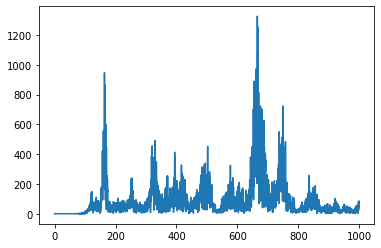

In [35]:
segment = wave.segment(start=4.5, duration=2.5)
segment.make_spectrum().plot(high=high)

Основная частота составляет 150 Гц. Следующие самые высокие пики находятся на 300 Гц и 750 Гц.

Это сегмент "о":

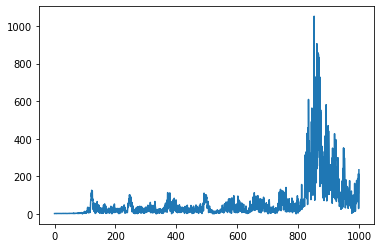

In [36]:
segment = wave.segment(start=7.5, duration=2)
segment.make_spectrum().plot(high=high)

Основная частота составляет 100 Гц. Следующие самые высокие пики находятся на частоте 900 Гц.

Это сегмент "у":

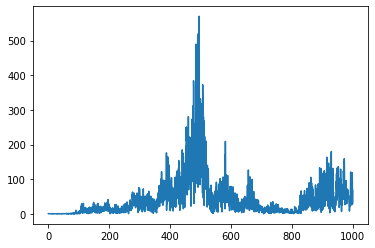

In [37]:
segment = wave.segment(start=10.2, duration=2)
segment.make_spectrum().plot(high=high)

Основной и самый высокий пик приходится на 500 Гц.